In [20]:
from jaxns.nested_sampling import NestedSampler
from jaxns.prior_transforms import PriorChain, UniformPrior, NormalPrior, HalfLaplacePrior
from jaxns.plotting import plot_cornerplot, plot_diagnostics
from jax.scipy.linalg import solve_triangular
from jax import random, jit, disable_jit
from jax import numpy as jnp
import pylab as plt

In [146]:
def lnlike(x, data, a, b, c, d, sigma):
    
    yhat = model(x, a, b, c, d)
    N = x.size
    
    term1 = -0.5 * N * jnp.log(2. * jnp.pi * sigma**2)
    term2 =  -0.5/sigma**2 * jnp.sum((y - yhat)**2)
    
    return term1 + term2

In [147]:
def model(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

def make_data(a=1, b=0, c=2, d=1, sigma=0.1):
    x = jnp.linspace(-3., 3, 100)[:, None]
    y = model(x, a, b, c, d) + sigma*random.normal(random.PRNGKey(0), shape=(100,1))
    return x, y

In [217]:
a_true = -4
b_true = 3
c_true = 25
d_true = 6
sigma_true = 0.1

In [218]:
x, y = make_data(a_true, b_true, c_true, d_true, sigma_true)

In [219]:
N = x.size

In [220]:
x.size

100

In [221]:
x.shape

(100, 1)

In [222]:
y.shape

(100, 1)

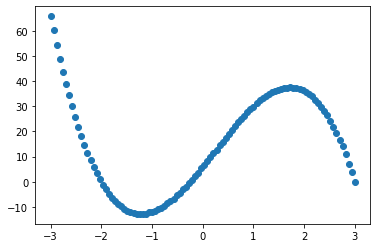

In [223]:
plt.figure()
plt.plot(x, y, 'o')
plt.show()

In [224]:
lnlike(x, y, 1, 0, 1, 0, 0.1)

DeviceArray(-3889935.44577189, dtype=float64)

In [225]:
b_grid = jnp.linspace(b_true-4, b_true+3, 100)
lns = jnp.array([lnlike(x, y, a_true, b, c_true, d_true, 0.1) for b in b_grid])

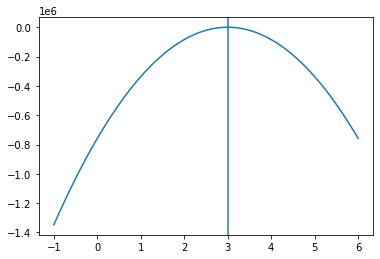

In [226]:
plt.figure()
# plt.plot(b_grid, jnp.exp(lns))
plt.plot(b_grid, lns)
plt.axvline(b_true)

In [228]:
# setup priors
prior_a = UniformPrior('a', -20., 20.)
prior_b = UniformPrior('b', -20., 20.)
prior_c = UniformPrior('c', 0, 40)
prior_d = UniformPrior('d', -20., 20.)
prior_sigma = HalfLaplacePrior('sigma', 1)

In [229]:
prior_chain = PriorChain().push(prior_a).push(prior_b).push(prior_c).push(prior_d).push(prior_sigma)

In [230]:
prior_chain

_sigma_b ~ (1,) : DeltaPrior([1])
sigma ~ (1,) : HalfLaplacePrior(_sigma_b)
_d_high ~ (1,) : DeltaPrior([20.])
_d_low ~ (1,) : DeltaPrior([-20.])
d ~ (1,) : UniformPrior(_d_low,_d_high)
_c_high ~ (1,) : DeltaPrior([40])
_c_low ~ (1,) : DeltaPrior([0])
c ~ (1,) : UniformPrior(_c_low,_c_high)
_b_high ~ (1,) : DeltaPrior([20.])
_b_low ~ (1,) : DeltaPrior([-20.])
b ~ (1,) : UniformPrior(_b_low,_b_high)
_a_high ~ (1,) : DeltaPrior([20.])
_a_low ~ (1,) : DeltaPrior([-20.])
a ~ (1,) : UniformPrior(_a_low,_a_high)

In [231]:
# lnlike(x, y, a, b, sigma)

In [232]:
log_likelihood = lambda a, b, c, d, sigma, **unused_kwargs: lnlike(x, y, a, b, c, d, sigma)[0]


In [233]:
# this doesn't work because of the [0] above
# log_likelihood(1, 0, 1, 1, 0.1)

In [234]:
ns = NestedSampler(log_likelihood, prior_chain, sampler_name='slice')

In [235]:
prior_chain(jnp.array([1,2,1,1,1]))

{'a': DeviceArray([20.], dtype=float64),
 '_a_low': DeviceArray([-20.], dtype=float64),
 '_a_high': DeviceArray([20.], dtype=float64),
 'b': DeviceArray([20.], dtype=float64),
 '_b_low': DeviceArray([-20.], dtype=float64),
 '_b_high': DeviceArray([20.], dtype=float64),
 'c': DeviceArray([40], dtype=int64),
 '_c_low': DeviceArray([0], dtype=int64),
 '_c_high': DeviceArray([40], dtype=int64),
 'd': DeviceArray([60.], dtype=float64),
 '_d_low': DeviceArray([-20.], dtype=float64),
 '_d_high': DeviceArray([20.], dtype=float64),
 'sigma': DeviceArray([inf], dtype=float64),
 '_sigma_b': DeviceArray([1], dtype=int64)}

In [236]:
log_likelihood(**prior_chain(jnp.array([1,2,1,1,1])))

DeviceArray(-inf, dtype=float64)

In [237]:
@jit
def run(key):
    return ns(key=key,
              num_live_points=500,
              max_samples=1e5,
              collect_samples=True,
              termination_frac=0.01)

In [238]:
%%time
# run with options
results = run(random.PRNGKey(0))

CPU times: user 8.93 s, sys: 86.1 ms, total: 9.02 s
Wall time: 9.02 s


In [239]:
type(results)

jaxns.nested_sampling.NestedSamplerResults

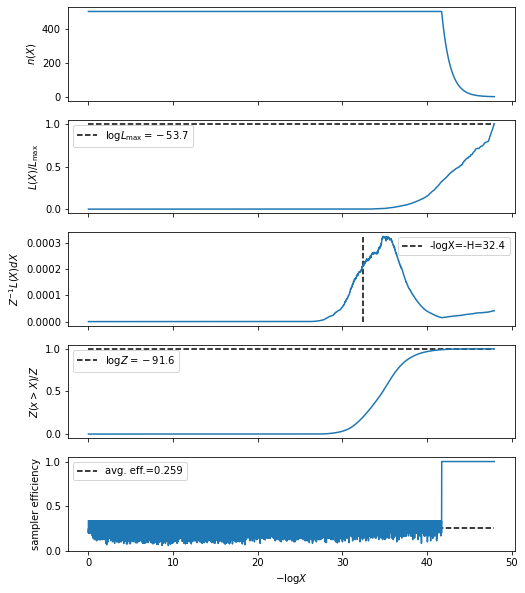

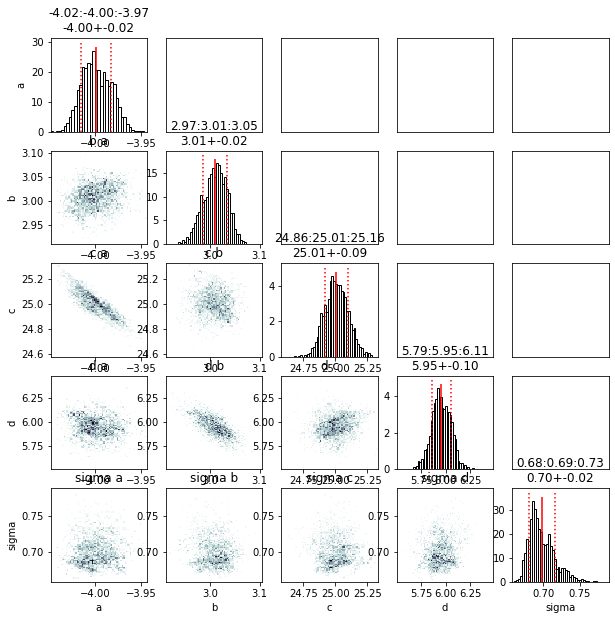

In [240]:
plot_diagnostics(results)
plot_cornerplot(results)

In [241]:
a_true

-4

In [242]:
b_true

3

In [243]:
c_true

25

In [244]:
d_true

6

In [245]:
sigma_true

0.1

In [246]:
jnp.exp(sigma_true)

DeviceArray(1.10517092, dtype=float64)

In [247]:
results.num_samples

DeviceArray(21382, dtype=int64)

In [248]:
results.samples['a'].size

100000

In [249]:
results.samples['a'][:,0]

DeviceArray([10.94080956, 16.18598063, 12.0034719 , ...,  0.        ,
              0.        ,  0.        ], dtype=float64)

In [250]:
a_samples = results.samples['a'][:results.num_samples, 0]
b_samples = results.samples['b'][:results.num_samples, 0]
c_samples = results.samples['c'][:results.num_samples, 0]
d_samples = results.samples['d'][:results.num_samples, 0]
sigma_samples = results.samples['sigma'][:results.num_samples, 0]

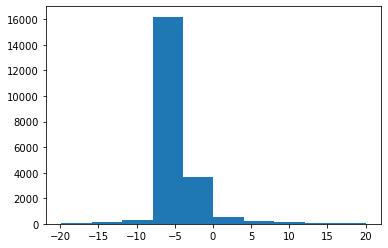

In [251]:
plt.figure()
plt.hist(a_samples);

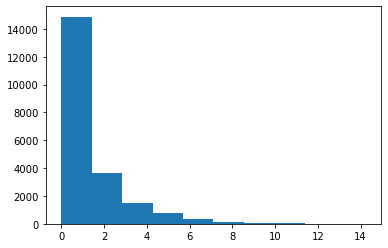

In [252]:
plt.figure()
plt.hist(sigma_samples);


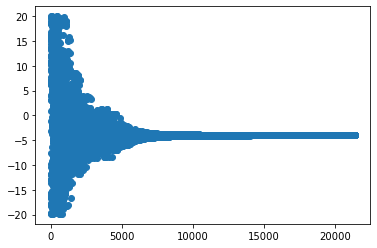

In [253]:
plt.figure()
# plt.plot(results.samples['a'][:,0], 'o')
plt.plot(a_samples,  'o')

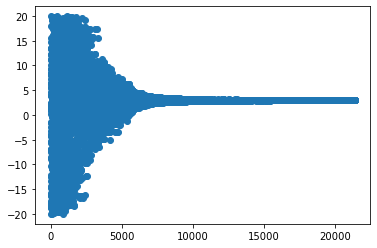

In [254]:
plt.figure()
plt.plot(b_samples,  'o')

In [255]:
a_5, a_50, a_95 = jnp.percentile(a_samples, [5, 50, 95])
b_5, b_50, b_95 = jnp.percentile(b_samples, [5, 50, 95])
c_5, c_50, c_95 = jnp.percentile(c_samples, [5, 50, 95])
d_5, d_50, d_95 = jnp.percentile(d_samples, [5, 50, 95])

In [256]:
print(a_5, a_50, a_95)
print(b_5, b_50, b_95)
print(c_5, c_50, c_95)
print(d_5, d_50, d_95)

-5.7301926612854 -3.999207019805908 -0.11354205757379532
-1.4130399227142334 3.0026278495788574 7.422335147857666
11.92009449005127 24.983753204345703 32.62575149536133
-5.897077560424805 5.957977294921875 13.11535358428955


In [257]:
random.randint(random.PRNGKey(0), (10,), 1, 10)

DeviceArray([6, 8, 7, 1, 6, 9, 6, 6, 9, 8], dtype=int64)

In [258]:
jnp.unique(random.randint(random.PRNGKey(0), (10,), 1, 10))

DeviceArray([1, 6, 7, 8, 9], dtype=int64)

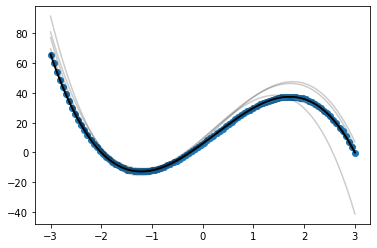

In [261]:
plt.figure()
plt.plot(x, y, 'o')
plt.plot(x, model(x, a_50, b_50, c_50, d_50), c='k')

rands = jnp.unique(random.randint(random.PRNGKey(3), (10,), 0, a_samples.size))
for rand in rands:
    plt.plot(x, model(x, a_samples[rand], b_samples[rand], c_samples[rand], d_samples[rand]), c='k', alpha=0.2)


plt.show()

# compare with dynesty

In [ ]:
# adapted from
# https://github.com/Joshuaalbert/jaxns/blob/master/jaxns/examples/compare_with_other_nested_sampling_packages.py#L54

In [ ]:
# from numpy import pi, log
# import pylab as plt
# from timeit import default_timer

# def run_dynest():
    
#     ndims = 2
#     sigma = 0.1
#     num_live_points = 100
    
#     try:
#         import dynesty
#     except:
#         raise ImportError("Dynesty not installed. Run `pip install dynesty`.")


#     def loglikelihood(theta):
#         """Multivariate normal log-likelihood."""
#         nDims = len(theta)
#         r2 = sum(theta**2)
#         logL = -log(2*pi*sigma*sigma)*nDims/2.0
#         logL += -r2/2/sigma/sigma
#         return logL

#     # prior transform (iid standard normal prior)
#     def prior_transform(u):
#         """Transforms our unit cube samples `u` to a standard normal prior."""
#         return u*2.-1.

#     sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndims,
#                                     nlive=num_live_points,
#                                     bound='single', sample='slice',
#                                     slices=25)
#     t0 = default_timer()
#     sampler.run_nested(dlogz=0.01)
#     res = sampler.results
#     print("Dynesty log(Z):",res['logz'])
#     run_time = default_timer()-t0
#     return run_time

# _ = run_dynest()

In [278]:
from numpy import pi, log
from numpy import sum as npsum
import pylab as plt
from timeit import default_timer

def run_dynest():
    

    num_live_points = 100
    
    try:
        import dynesty
    except:
        raise ImportError("Dynesty not installed. Run `pip install dynesty`.")


    def loglikelihood(theta):
        
        a, b, c, d, sigma = theta
        yhat = model(x, a, b, c, d)
        
        N = x.shape[0]

        term1 = -0.5 * N * log(2. * pi * sigma**2)
        term2 =  -0.5/sigma**2 * npsum((y - yhat)**2)

        return term1 + term2

    # prior transform (iid standard normal prior)
    def prior_transform(utheta):
        """Transforms our unit cube samples `u` to a standard normal prior."""
        ua, ub, uc, ud, us = utheta
        
        a = (2*ua-1) * 5
        b = (2*ub-1) * 5
        c = 25*uc + 8
        d = (2*ud-1) * 20
        
        sigma = 11*us - 10.
        
        return a,b,c,d,sigma
        
#     sampler = dynesty.NestedSampler(loglikelihood, prior_transform, 5,
#                                     nlive=num_live_points,
#                                     bound='single', sample='slice',
#                                     slices=25)
    sampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, 5,
                                    nlive=num_live_points,
                                    bound='multi', sample='rstagger')
    
    
    
    t0 = default_timer()
#     sampler.run_nested(dlogz=0.01)
    sampler.run_nested()
    res = sampler.results
    print("Dynesty log(Z):",res['logz'])
    run_time = default_timer()-t0
    print(f"run_time = {run_time}")
    return res

dynest_res = run_dynest()

2172it [00:52, 20.80it/s, batch: 0 | bound: 5 | nc: 25 | ncall: 26887 | eff(%):  7.931 | loglstar:   -inf < -403.358 <    inf | logz: -411.582 +/-  0.172 | dlogz: 179.504 >  0.010]   /Users/spx8sk/anaconda3/envs/jax/lib/python3.7/site-packages/dynesty/sampling.py:371: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
30276it [24:59, 20.19it/s, batch: 7 | bound: 339 | nc: 25 | ncall: 717489 | eff(%):  4.220 | loglstar: 75.731 < 82.528 < 81.146 | logz: 46.596 +/-  0.359 | stop:  0.969]             

Dynesty log(Z): [-1.51874456e+11 -1.39803799e+10 -1.18644305e+08 ...  4.65703063e+01
  4.65703266e+01  4.65703471e+01]


In [280]:
a_true

-4

In [281]:
c_true

25

In [282]:
d_true

6

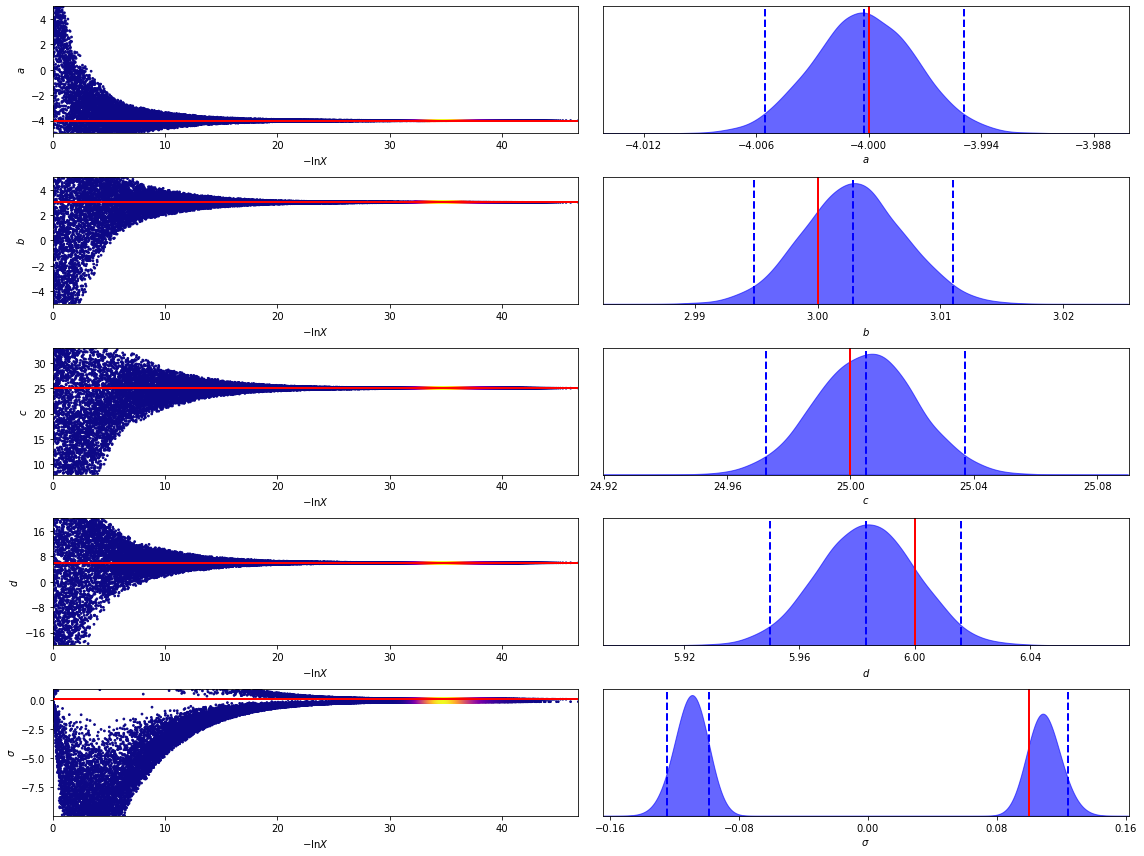

In [283]:
from dynesty import plotting as dyplot

truths = [a_true, b_true, c_true, d_true, sigma_true]
labels = [r'$a$', r'$b$', r'$c$', r'$d$', r'$\sigma$']
fig, axes = dyplot.traceplot(dynest_res, truths=truths, labels=labels,
                             fig=plt.subplots(5, 2, figsize=(16, 12)))
fig.tight_layout()

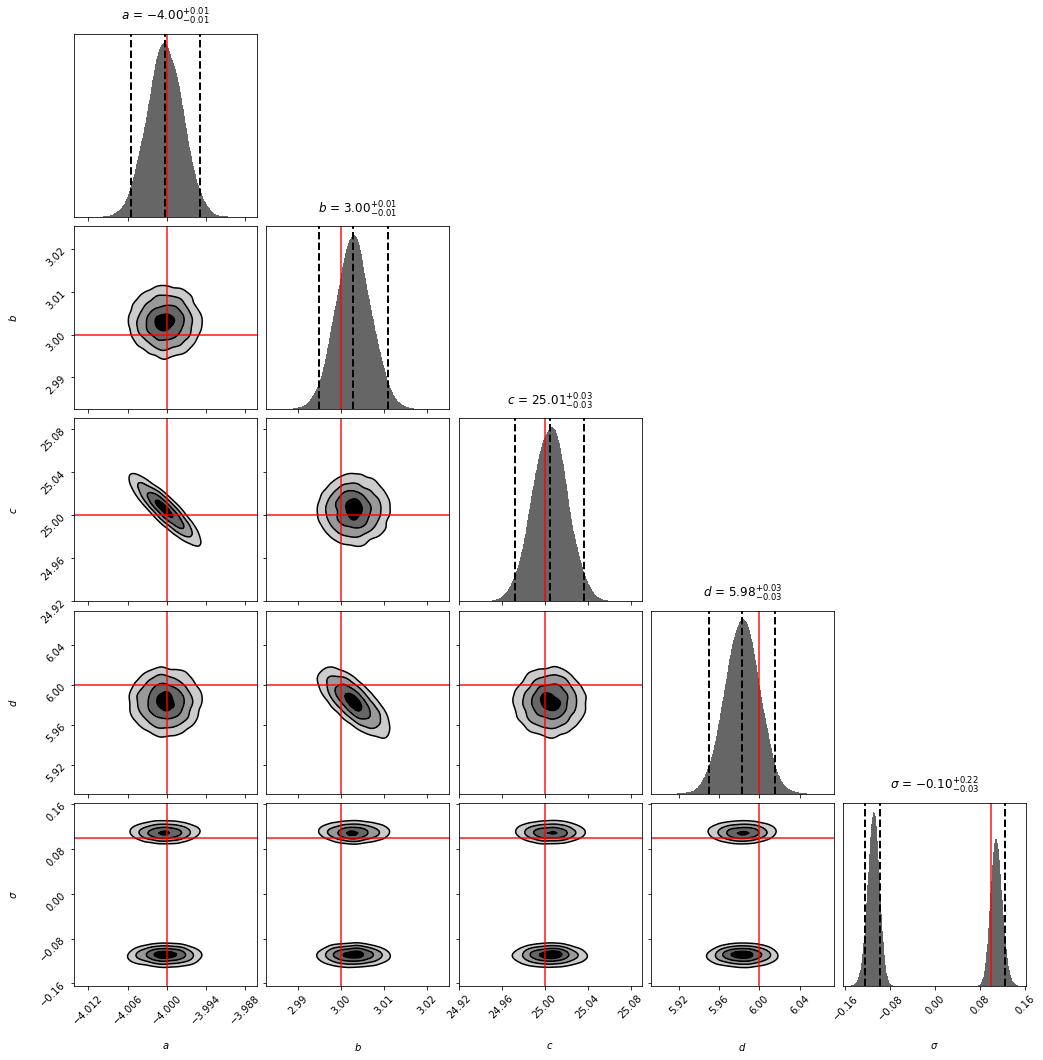

In [284]:
fig, axes = dyplot.cornerplot(dynest_res, truths=truths, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(5, 5, figsize=(15, 15)))

In [285]:
dynest_res.keys()

dict_keys(['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'batch_nlive', 'batch_bounds', 'bound', 'bound_iter', 'samples_bound', 'scale'])

In [286]:
dy_a = jnp.median(dynest_res['samples'][:,0])
dy_b = jnp.median(dynest_res['samples'][:,1])
dy_c = jnp.median(dynest_res['samples'][:,2])
dy_d = jnp.median(dynest_res['samples'][:,3])

print(dy_a)
print(dy_b)
print(dy_c)
print(dy_d)

-3.9997903869348836
3.002454244860255
25.003044529574602
5.983184604518916


In [287]:
a_true

-4

In [288]:
b_true

3

In [289]:
c_true

25

In [290]:
d_true

6

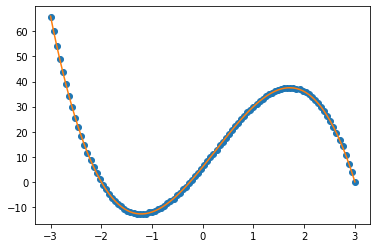

In [291]:
plt.figure()
plt.plot(x, y, 'o')
# plt.plot(x, model(x, dy_a, dy_b, dy_c, 6), c='k')
plt.plot(x, model(x, a_true, b_true, c_true, d_true), c='C1')

# rands = jnp.unique(random.randint(random.PRNGKey(6), (10,), 0, a_samples.size))
# for rand in rands:
#     plt.plot(x, model(x, a_samples[rand], b_samples[rand], c_samples[rand], d_samples[rand]), c='k', alpha=0.2)


plt.show()